In [1]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.5 MB/s eta 0:00:00


In [3]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import random
import tensorflow as tf

In [4]:
%matplotlib inline

In [5]:
minmaxscaler = MinMaxScaler()

In [6]:
dataset_root_folder = '/content/drive/MyDrive/Colab Notebooks/'
dataset_name = 'data'

In [7]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = k.flatten(y_true)
  y_pred_flatten = k.flatten(y_pred)
  intersection = k.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (k.sum(y_true_flatten) + k.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [8]:
weights = [0.166, 0.166, 0.166, 0.166, 0.166, 0.166]

In [9]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [10]:
dice_loss = sm.losses.DiceLoss(class_weights=weights)

In [11]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [12]:
total_loss = dice_loss + (1 * focal_loss)

In [13]:
from tensorflow.keras.models import load_model
#load_model??
model = load_model("/content/drive/MyDrive/Colab Notebooks/imagesattelitesegmentation500.h5",
                   custom_objects=({'dice_loss_plus_1focal_loss': total_loss,
                                    'jaccard_coef': jaccard_coef}), compile=True, safe_mode=True)

In [14]:
def patched_image(image):
  image = np.array(image)
  patched_image_list = []
  image_patch_size = 256
  size_x = (image.shape[1]//image_patch_size) * image_patch_size
  size_y = (image.shape[0]//image_patch_size) * image_patch_size
  image = Image.fromarray(image)
  image = image.crop((0, 0, size_x, size_y))
  image = np.array(image)
  patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)

  for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            individual_patched_image = patched_images[i, j]
            individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
            #individual_patched_image = Image.fromarray(individual_patched_image)
            individual_patched_image = individual_patched_image[0]
            #print(individual_patched_image.shape)
            patched_image_list.append(individual_patched_image)
  return patched_image_list

In [33]:
image = Image.open('/content/drive/MyDrive/Colab Notebooks/Images_test/iut.jpeg')

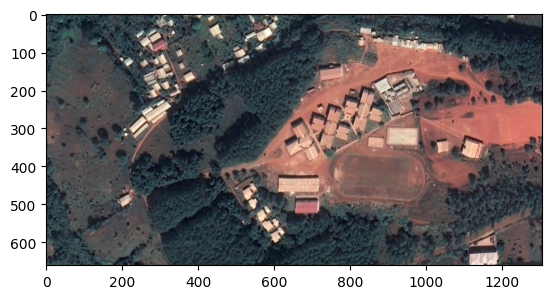

In [34]:
plt.imshow(image)

In [35]:
patched_image_list = patched_image(image)

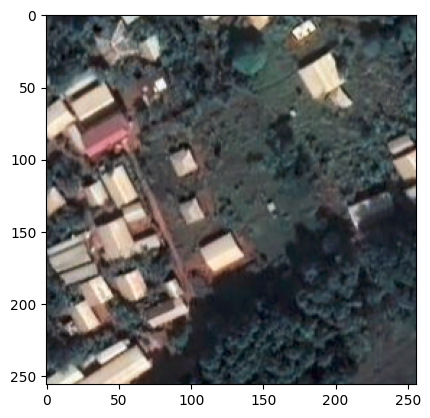

In [36]:
i = 1
# nbr = len(patched_image_list)
# for image in patched_image_list:
#   plt.figure(figsize=(20,16))
#   plt.subplot(nbr//2,nbr,i)
#   plt.imshow(image)
#   i += 1
plt.imshow(patched_image_list[1])

In [37]:
predict_image_list = []

# for image in patched_image_list:
#   image = np.expand_dims(image, 0)
#   predict = model.predict(image)
#   predict_image = np.argmax(predict, axis=3)
#   predict_image = predict_image[0, :, :]
#   predict_image_list.append(predict_image)

image = np.expand_dims(patched_image_list[1], 0)
predict = model.predict(image)
predict_image = np.argmax(predict, axis=3)
predict_image = predict_image[0, :, :]

1/1 [==============================] - 0s 186ms/step


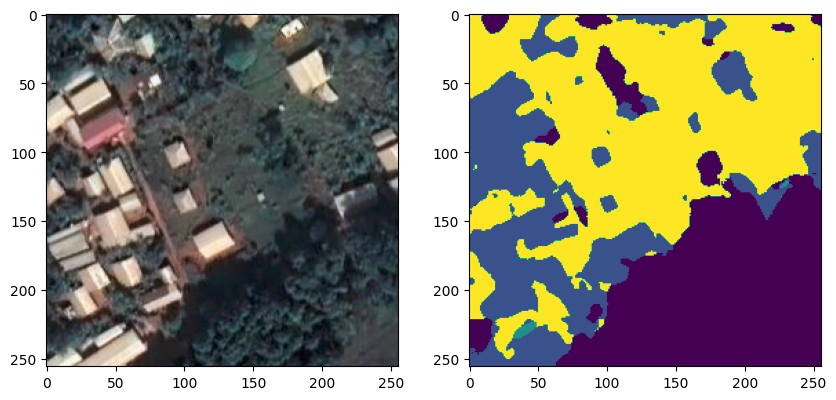

In [38]:
# for image in predict_image_list:
#   #image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
#   plt.figure(figsize=(10,8))
#   plt.subplot(nbr//2,nbr,i)
#   plt.imshow(image)
#   i += 1
plt.figure(figsize=(10,8))
plt.subplot(121)
plt.imshow(patched_image_list[1])
plt.subplot(122)
plt.imshow(predict_image)

In [21]:
image = Image.open('/content/drive/MyDrive/Colab Notebooks/Images_test/kribi.jpeg')
image = image.resize((256,256))
image = np.array(image)
image = np.expand_dims(image, 0)
predict = model.predict(image)

1/1 [==============================] - 1s 723ms/step


In [22]:
predicted_image = np.argmax(predict, axis=3)
predicted_image = predicted_image[0]

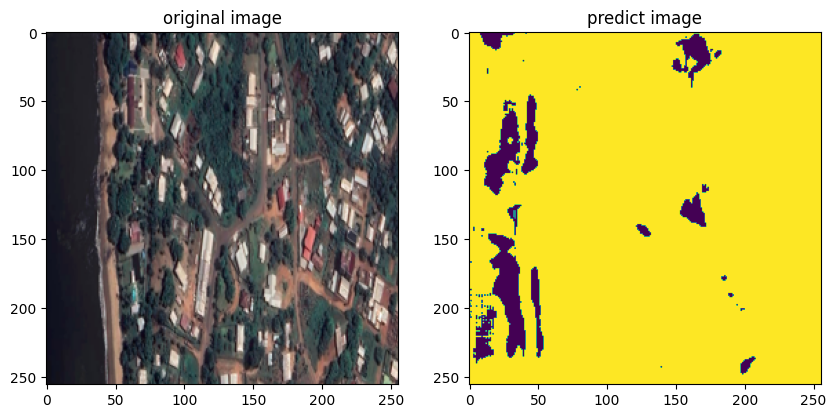

In [23]:
image = Image.open('/content/drive/MyDrive/Colab Notebooks/Images_test/kribi.jpeg')
image = image.resize((256,256))

plt.figure(figsize=(10,8))
plt.subplot(121)
plt.title("original image")
plt.imshow(image)
plt.subplot(122)
plt.title("predict image")
plt.imshow(predicted_image)


In [24]:
!pip install keract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
import keract as ke

In [52]:
image = np.array(patched_image_list[1])
image = np.expand_dims(image, 0)
image.shape

(1, 256, 256, 3)

In [53]:
activations = ke.get_activations(model, image, nodes_to_evaluate=None, output_format='simple', auto_compile=True)

In [54]:
!ls

activations  drive  sample_data


In [55]:
ke.display_activations(activations, cmap='viridis', save=True, directory='activations')

input_1 (1, 256, 256, 3) 
conv2d (1, 256, 256, 16) 
dropout (1, 256, 256, 16) 
conv2d_1 (1, 256, 256, 16) 
max_pooling2d (1, 128, 128, 16) 
conv2d_2 (1, 128, 128, 32) 
dropout_1 (1, 128, 128, 32) 
conv2d_3 (1, 128, 128, 32) 
max_pooling2d_1 (1, 64, 64, 32) 
conv2d_4 (1, 64, 64, 64) 
dropout_2 (1, 64, 64, 64) 
conv2d_5 (1, 64, 64, 64) 
max_pooling2d_2 (1, 32, 32, 64) 
conv2d_6 (1, 32, 32, 128) 
dropout_3 (1, 32, 32, 128) 
conv2d_7 (1, 32, 32, 128) 
max_pooling2d_3 (1, 16, 16, 128) 
conv2d_8 (1, 16, 16, 256) 
dropout_4 (1, 16, 16, 256) 
conv2d_9 (1, 16, 16, 256) 
conv2d_transpose (1, 32, 32, 128) 
concatenate (1, 32, 32, 256) 
conv2d_10 (1, 32, 32, 128) 
dropout_5 (1, 32, 32, 128) 
conv2d_11 (1, 32, 32, 128) 
conv2d_transpose_1 (1, 64, 64, 64) 
concatenate_1 (1, 64, 64, 128) 
conv2d_12 (1, 64, 64, 64) 
dropout_6 (1, 64, 64, 64) 
conv2d_13 (1, 64, 64, 64) 
conv2d_transpose_2 (1, 128, 128, 32) 
concatenate_2 (1, 128, 128, 64) 
conv2d_14 (1, 128, 128, 32) 
dropout_7 (1, 128, 128, 32) 
conv2

In [57]:
image = np.array(patched_image_list[1])
image = np.expand_dims(image, 0)
image = np.array(image)
image = image.astype(np.float32)
image.shape

(1, 256, 256, 3)

In [58]:
ke.display_heatmaps(activations, image, save=True, directory="heatmap")

input_1 (1, 256, 256, 3) 
conv2d (1, 256, 256, 16) 
dropout (1, 256, 256, 16) 
conv2d_1 (1, 256, 256, 16) 
max_pooling2d (1, 128, 128, 16) 
conv2d_2 (1, 128, 128, 32) 
dropout_1 (1, 128, 128, 32) 
conv2d_3 (1, 128, 128, 32) 
max_pooling2d_1 (1, 64, 64, 32) 
conv2d_4 (1, 64, 64, 64) 
dropout_2 (1, 64, 64, 64) 
conv2d_5 (1, 64, 64, 64) 
max_pooling2d_2 (1, 32, 32, 64) 
conv2d_6 (1, 32, 32, 128) 
dropout_3 (1, 32, 32, 128) 
conv2d_7 (1, 32, 32, 128) 
max_pooling2d_3 (1, 16, 16, 128) 
conv2d_8 (1, 16, 16, 256) 
dropout_4 (1, 16, 16, 256) 
conv2d_9 (1, 16, 16, 256) 
conv2d_transpose (1, 32, 32, 128) 
concatenate (1, 32, 32, 256) 
conv2d_10 (1, 32, 32, 128) 
dropout_5 (1, 32, 32, 128) 
conv2d_11 (1, 32, 32, 128) 
conv2d_transpose_1 (1, 64, 64, 64) 
concatenate_1 (1, 64, 64, 128) 
conv2d_12 (1, 64, 64, 64) 
dropout_6 (1, 64, 64, 64) 
conv2d_13 (1, 64, 64, 64) 
conv2d_transpose_2 (1, 128, 128, 32) 
concatenate_2 (1, 128, 128, 64) 
conv2d_14 (1, 128, 128, 32) 
dropout_7 (1, 128, 128, 32) 
conv2